<a href="https://colab.research.google.com/github/Kruglikle/EduText-Analyzer/blob/main/ex_types_en.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Моделька на Logistic Regression с TF-IDF и кросс-валидацией через GridSearchCV.

✅ Разделение данных с stratify=y → корректное распределение классов

✅ TF-IDF + LogisticRegression → классический baseline

✅ GridSearch по гиперпараметрам модели и векторизатора

✅ f1_macro как основная метрика (идеально для несбалансированных классов)

✅ Сохранение всего пайплайна в .pkl → готово к переиспользованию / inference

In [ ]:
import pandas as pd
import re
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, f1_score

# === 2. Загрузка данных ===
df = pd.read_excel("test-train-en.xlsx")  # колонки: "text", "label"

X = df["text"]
y = df["label"]

# === 3. Разделение ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# === 4. Пайплайн ===
# Важно: НЕ используем lowercase=True, потому что уже делаем .lower() в preprocess_text
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        preprocessor=None,          # не нужен — обработка уже сделана
        tokenizer=None,
        lowercase=False,            # уже lowercased
        strip_accents='unicode',
        ngram_range=(1, 1),         # будет перебрано в GridSearch
        min_df=1                    # будет перебрано в GridSearch
    )),
    ('clf', LogisticRegression(max_iter=3000, random_state=42))
])

# === 5. Сетка гиперпараметров ===
param_grid = {
    'tfidf__ngram_range': [(1,1), (1,2)],
    'tfidf__min_df': [1, 2, 3],
    'clf__C': [0.1, 1, 10],
    'clf__solver': ['liblinear', 'saga'],
    'clf__penalty': ['l1', 'l2']  # liblinear поддерживает l1 и l2
}

# === 6. Поиск лучших параметров ===
print("Запуск GridSearchCV...")
grid = GridSearchCV(
    pipeline,
    param_grid,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train, y_train)

# === 7. Оценка ===
print("\n✅ Лучшие параметры:", grid.best_params_)
print("✅ Лучший F1 (CV):", grid.best_score_)

y_pred = grid.predict(X_test)
print("\n✅ Test Accuracy:", accuracy_score(y_test, y_pred))
print("\n✅ Classification Report:\n", classification_report(y_test, y_pred))

# === 8. Сохранение ВСЕГО пайплайна ===
joblib.dump(grid.best_estimator_, "best_en_pipeline.pkl")
print("\n✅ Модель успешно сохранена как 'best_en_pipeline.pkl'")

Запуск GridSearchCV...
Fitting 5 folds for each of 72 candidates, totalling 360 fits


KeyboardInterrupt: 

In [ ]:
print("Количество признаков в векторизаторе:", vectorizer.get_feature_names_out().shape[0])
print("Модель ожидает признаков:", clf.n_features_in_)

Количество признаков в векторизаторе: 5846
Модель ожидает признаков: 384


**Подгружаем модель**

Рабочий

In [ ]:
import pandas as pd
import joblib
import re

# === 2. Загружаем ВЕСЬ пайплайн (модель + векторизатор вместе) ===
pipeline = joblib.load("best_en_pipeline.pkl")  # ← имя файла из обучения

# === 3. Загружаем gold-standard данные ===
df = pd.read_csv("forward-gold-standard.csv")  # должна быть колонка "text"

# === 5. Делаем предсказание за один вызов ===
# Пайплайн сам сделает TF-IDF и предскажет
preds = pipeline.predict(df["text"])

# === 6. Сохраняем результат ===
df["label"] = preds
df.to_csv("pred.csv", index=False, encoding='utf-8-sig')
print("✅ Результат сохранён в 'pred.csv'")

✅ Результат сохранён в 'pred.csv'


In [ ]:
import pandas as pd
import joblib
import re

# Загружаем модель и TF-IDF
clf = joblib.load("english_logreg_model.pkl")
vectorizer = joblib.load("english_tfidf_vectorizer.pkl")

# Функция препроцессинга (совпадает с обучением)
def merge_split_words(text):
    return re.sub(r'(\w+)-\s+(\w+)', r'\1\2', text)

def clean_text(text):
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()

def preprocess_russian(text):
    text = text.lower()
    text = merge_split_words(text)
    text = clean_text(text)
    return text

# Чтение CSV с подготовленным текстом
df = pd.read_csv("forward-gold.csv")  # колонка "exercise"
exercises_clean = df["text"].apply(preprocess_russian)

# Векторизация и предсказание
X_tfidf = vectorizer.transform(exercises_clean)
preds = clf.predict(X_tfidf)

# Сохраняем результат
df["label"] = preds
df.to_csv("pred.csv", index=False, encoding='utf-8-sig')
print("Результат сохранён")


ValueError: X has 5846 features, but LogisticRegression is expecting 384 features as input.

**Confusion matrix**

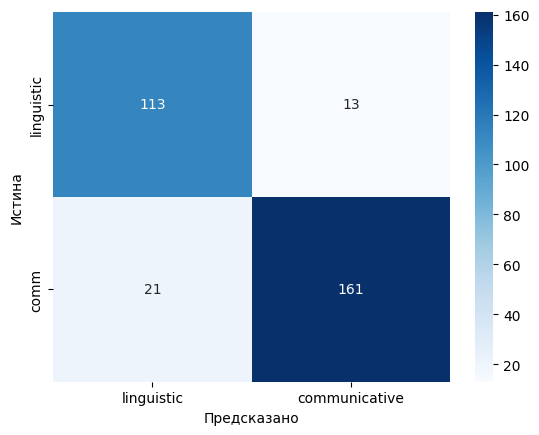

               precision    recall  f1-score   support

communicative      0.925     0.885     0.904       182
   linguistic      0.843     0.897     0.869       126

     accuracy                          0.890       308
    macro avg      0.884     0.891     0.887       308
 weighted avg      0.892     0.890     0.890       308



In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Загружаем файлы
gold = pd.read_csv("forward-gold-standard-answers.csv")   # должно быть: text, label
pred = pd.read_csv("pred1-en.csv")   # должно быть: text, label или label_pred

# убираем лишние пробелы в названиях колонок
gold.columns = gold.columns.str.strip()
pred.columns = pred.columns.str.strip()

# --- Обработка названий колонок ---
# у gold должна быть колонка label → label_true
if "label" in gold.columns:
    gold = gold.rename(columns={"label": "label_true"})

# у pred может быть label или label_pred
if "label" in pred.columns:
    pred = pred.rename(columns={"label": "label_pred"})

# объединяем по text
df = pd.merge(gold, pred, on="text")

# Матрица ошибок
cm = confusion_matrix(df["label_true"], df["label_pred"],
                      labels=["linguistic", "communicative"])

# Визуализация
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["linguistic", "communicative"],
            yticklabels=["linguistic", "comm"])
plt.xlabel("Предсказано")
plt.ylabel("Истина")
plt.show()

# Отчёт
print(classification_report(df["label_true"], df["label_pred"], digits=3))


Еще модельки

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# === Загрузка данных ===
df = pd.read_excel("test-train-en.xlsx")  # или твой актуальный файл
X = df["text"]
y = df["label"]

# === Разделение ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score

# === TF-IDF ===
tfidf = TfidfVectorizer(strip_accents='unicode', ngram_range=(1,2), min_df=2)

# === Модели ===
models = {
    "LogReg": (LogisticRegression(max_iter=3000, random_state=42),
               {'clf__C': [0.1, 1, 10]}),
    "SVM": (SVC(random_state=42),
            {'clf__C': [0.1, 1, 10], 'clf__kernel': ['linear', 'rbf']}),
    "kNN": (KNeighborsClassifier(),
            {'clf__n_neighbors': [3, 5, 7]}),
    "RandomForest": (RandomForestClassifier(random_state=42),
                     {'clf__n_estimators': [100, 200]}),
    "Bagging": (BaggingClassifier(random_state=42),
                {'clf__n_estimators': [50, 100]}),
    "GradBoost": (GradientBoostingClassifier(random_state=42),
                  {'clf__n_estimators': [100, 200], 'clf__learning_rate': [0.05, 0.1]})
}

# === Основные метрики для всех моделей ===
summary_results = []

# === F1 по каждому классу для каждой модели ===
per_class_reports = {}

for name, (clf, params) in models.items():
    print(f"\n Обучение модели: {name}")
    pipe = Pipeline([('tfidf', tfidf), ('clf', clf)])
    grid = GridSearchCV(pipe, param_grid=params, scoring='f1_macro', cv=5, n_jobs=-1)
    grid.fit(X_train, y_train)

    y_pred = grid.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    print(f" {name} — лучший F1 (CV): {grid.best_score_:.3f}, Test F1 (macro): {f1_macro:.3f}, Accuracy: {acc:.3f}")

    summary_results.append([name, grid.best_score_, f1_macro, acc])

    # F1 по каждому классу
    report_dict = classification_report(y_test, y_pred, output_dict=True)
    per_class_reports[name] = pd.DataFrame(report_dict).transpose()

# === Сохраняем сводную таблицу ===
summary_df = pd.DataFrame(summary_results, columns=["Model", "CV_F1", "Test_F1_macro", "Accuracy"])
summary_df.to_excel("model_summary_results.xlsx", index=False)
print("Сводная таблица с основными метриками сохранена: 'model_summary_results.xlsx'")

# === Сохраняем F1 по каждому классу для каждой модели ===
for name, df_report in per_class_reports.items():
    df_report.to_excel(f"{name}_per_class_report.xlsx")
    print(f" F1 по классам для {name} сохранён в '{name}_per_class_report.xlsx'")



 Обучение модели: LogReg
 LogReg — лучший F1 (CV): 0.844, Test F1 (macro): 0.779, Accuracy: 0.779

 Обучение модели: SVM
 SVM — лучший F1 (CV): 0.838, Test F1 (macro): 0.793, Accuracy: 0.793

 Обучение модели: kNN
 kNN — лучший F1 (CV): 0.792, Test F1 (macro): 0.751, Accuracy: 0.751

 Обучение модели: RandomForest
 RandomForest — лучший F1 (CV): 0.802, Test F1 (macro): 0.765, Accuracy: 0.765

 Обучение модели: Bagging
 Bagging — лучший F1 (CV): 0.764, Test F1 (macro): 0.746, Accuracy: 0.747

 Обучение модели: GradBoost
 GradBoost — лучший F1 (CV): 0.801, Test F1 (macro): 0.751, Accuracy: 0.751
Сводная таблица с основными метриками сохранена: 'model_summary_results.xlsx'
 F1 по классам для LogReg сохранён в 'LogReg_per_class_report.xlsx'
 F1 по классам для SVM сохранён в 'SVM_per_class_report.xlsx'
 F1 по классам для kNN сохранён в 'kNN_per_class_report.xlsx'
 F1 по классам для RandomForest сохранён в 'RandomForest_per_class_report.xlsx'
 F1 по классам для Bagging сохранён в 'Bagging_p

In [ ]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from joblib import dump, load

# === TF-IDF ===
tfidf = TfidfVectorizer(strip_accents='unicode', ngram_range=(1,2), min_df=2)

# === Модели ===
models = {
    "LogReg": LogisticRegression(max_iter=3000, random_state=42),
    "SVM": SVC(random_state=42, probability=True),
    "kNN": KNeighborsClassifier(),
    "RandomForest": RandomForestClassifier(random_state=42),
    "Bagging": BaggingClassifier(random_state=42),
    "GradBoost": GradientBoostingClassifier(random_state=42)
}

# === Словари для результатов ===
summary_results = []
per_class_reports = {}

# === Обучение, предсказания и сохранение моделей ===
for name, clf in models.items():
    print(f"\n=== Обучаем модель: {name} ===")
    pipe = Pipeline([('tfidf', tfidf), ('clf', clf)])
    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    print(f"{name}: Accuracy={acc:.3f}, F1_macro={f1_macro:.3f}")

    summary_results.append([name, f1_macro, acc])

    # F1 по каждому классу
    report_dict = classification_report(y_test, y_pred, output_dict=True)
    per_class_reports[name] = pd.DataFrame(report_dict).transpose()

    # Сохраняем pipeline в .pkl
    dump(pipe, f"{name}_pipeline.pkl")
    print(f"Модель {name} сохранена как '{name}_pipeline.pkl'")

# === Сводная таблица метрик ===
summary_df = pd.DataFrame(summary_results, columns=["Model", "F1_macro", "Accuracy"])
summary_df.to_excel("model_summary_results.xlsx", index=False)
print("\nСводная таблица с основными метриками сохранена: 'model_summary_results.xlsx'")

# === Сохраняем F1 по каждому классу ===
for name, df_report in per_class_reports.items():
    df_report.to_excel(f"{name}_per_class_report.xlsx")
    print(f"F1 по классам для {name} сохранён в '{name}_per_class_report.xlsx'")



=== Обучаем модель: LogReg ===
LogReg: Accuracy=0.779, F1_macro=0.779
Модель LogReg сохранена как 'LogReg_pipeline.pkl'

=== Обучаем модель: SVM ===
SVM: Accuracy=0.793, F1_macro=0.793
Модель SVM сохранена как 'SVM_pipeline.pkl'

=== Обучаем модель: kNN ===
kNN: Accuracy=0.756, F1_macro=0.756
Модель kNN сохранена как 'kNN_pipeline.pkl'

=== Обучаем модель: RandomForest ===
RandomForest: Accuracy=0.765, F1_macro=0.765
Модель RandomForest сохранена как 'RandomForest_pipeline.pkl'

=== Обучаем модель: Bagging ===
Bagging: Accuracy=0.710, F1_macro=0.709
Модель Bagging сохранена как 'Bagging_pipeline.pkl'

=== Обучаем модель: GradBoost ===
GradBoost: Accuracy=0.747, F1_macro=0.746
Модель GradBoost сохранена как 'GradBoost_pipeline.pkl'

Сводная таблица с основными метриками сохранена: 'model_summary_results.xlsx'
F1 по классам для LogReg сохранён в 'LogReg_per_class_report.xlsx'
F1 по классам для SVM сохранён в 'SVM_per_class_report.xlsx'
F1 по классам для kNN сохранён в 'kNN_per_class_rep

Прогоняем модели через gold standard

In [ ]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier

# Загрузка gold standard
df_gold = pd.read_excel("forward-gold-standard-answers.xlsx")
X_gold = df_gold['text']
y_gold = df_gold['label']

# TF-IDF
tfidf = TfidfVectorizer(strip_accents='unicode', ngram_range=(1,2), min_df=2)

# Список моделей
models = {
    "LogReg": LogisticRegression(max_iter=3000, random_state=42),
    "SVM": SVC(random_state=42, kernel='linear'),
    "kNN": KNeighborsClassifier(n_neighbors=5),
    "RandomForest": RandomForestClassifier(random_state=42, n_estimators=200),
    "Bagging": BaggingClassifier(random_state=42, n_estimators=100),
    "GradBoost": GradientBoostingClassifier(random_state=42, n_estimators=200, learning_rate=0.1)
}

# Создаём датафрейм для результатов
results_df = pd.DataFrame()
results_df['text'] = X_gold
results_df['true_label'] = y_gold

# Прогон моделей
for name, clf in models.items():
    pipe = Pipeline([('tfidf', tfidf), ('clf', clf)])
    pipe.fit(X_train, y_train)  # обучаем на полном train-корпусе
    results_df[f'{name}_pred'] = pipe.predict(X_gold)

# Сохраняем в Excel для дальнейшего анализа
results_df.to_excel("gold_standard_predictions.xlsx", index=False)
print("✅ Таблица с предсказаниями сохранена в 'gold_standard_predictions.xlsx'")


✅ Таблица с предсказаниями сохранена в 'gold_standard_predictions.xlsx'


In [ ]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report

# === Загрузка gold standard ===
df_gold = pd.read_excel("forward-gold-standard-answers.xlsx")
X_gold = df_gold['text']
y_gold = df_gold['label']

# === TF-IDF ===
tfidf = TfidfVectorizer(strip_accents='unicode', ngram_range=(1,2), min_df=2)

# === Модели ===
models = {
    "LogReg": LogisticRegression(max_iter=3000, random_state=42),
    "SVM": SVC(random_state=42, kernel='linear'),
    "kNN": KNeighborsClassifier(n_neighbors=5),
    "RandomForest": RandomForestClassifier(random_state=42, n_estimators=200),
    "Bagging": BaggingClassifier(random_state=42, n_estimators=100),
    "GradBoost": GradientBoostingClassifier(random_state=42, n_estimators=200, learning_rate=0.1)
}

# === DataFrame для метрик ===
all_metrics = {}

for name, clf in models.items():
    pipe = Pipeline([('tfidf', tfidf), ('clf', clf)])
    pipe.fit(X_train, y_train)  # Обучаем на основном train-корпусе
    y_pred = pipe.predict(X_gold)

    # Получаем классификационный отчет как DataFrame
    report_dict = classification_report(y_gold, y_pred, output_dict=True)
    report_df = pd.DataFrame(report_dict).transpose()

    # Сохраняем в словарь
    all_metrics[name] = report_df

    # Сохраняем в отдельный Excel для каждой модели
    report_df.to_excel(f"gold_standard_metrics_{name}.xlsx")
    print(f" Метрики для {name} сохранены в 'gold_standard_metrics_{name}.xlsx'")

print(" Все метрики сохранены.")


 Метрики для LogReg сохранены в 'gold_standard_metrics_LogReg.xlsx'
 Метрики для SVM сохранены в 'gold_standard_metrics_SVM.xlsx'
 Метрики для kNN сохранены в 'gold_standard_metrics_kNN.xlsx'
 Метрики для RandomForest сохранены в 'gold_standard_metrics_RandomForest.xlsx'
 Метрики для Bagging сохранены в 'gold_standard_metrics_Bagging.xlsx'
 Метрики для GradBoost сохранены в 'gold_standard_metrics_GradBoost.xlsx'
 Все метрики сохранены.


In [ ]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score, accuracy_score

# === Загрузка gold standard ===
df_gold = pd.read_excel("forward-gold-standard-answers.xlsx")
X_gold = df_gold['text']
y_gold = df_gold['label']

# === TF-IDF ===
tfidf = TfidfVectorizer(strip_accents='unicode', ngram_range=(1,2), min_df=2)

# === Модели ===
models = {
    "LogReg": LogisticRegression(max_iter=3000, random_state=42),
    "SVM": SVC(random_state=42, kernel='linear'),
    "kNN": KNeighborsClassifier(n_neighbors=5),
    "RandomForest": RandomForestClassifier(random_state=42, n_estimators=200),
    "Bagging": BaggingClassifier(random_state=42, n_estimators=100),
    "GradBoost": GradientBoostingClassifier(random_state=42, n_estimators=200, learning_rate=0.1)
}

# === Создаём итоговую таблицу ===
results = []

for name, clf in models.items():
    # Pipeline с TF-IDF
    pipe = Pipeline([('tfidf', tfidf), ('clf', clf)])

    # Обучаем на всей тренировочной выборке
    pipe.fit(X_train, y_train)  # X_train и y_train — полный train-корпус (1082 формулировки)

    # Предсказания на gold standard
    y_pred = pipe.predict(X_gold)

    # Метрики
    f1_macro = f1_score(y_gold, y_pred, average='macro')
    acc = accuracy_score(y_gold, y_pred)

    results.append([name, f1_macro, acc])

# === Таблица результатов ===
gold_results_df = pd.DataFrame(results, columns=["Model", "F1_macro", "Accuracy"])
print(gold_results_df)

# === Сохраняем в Excel ===
gold_results_df.to_excel("gold_standard_results_common.xlsx", index=False)
print("✅ Таблица с результатами gold standard сохранена в 'gold_standard_results_common.xlsx'")


          Model  F1_macro  Accuracy
0        LogReg  0.871041  0.873333
1           SVM  0.864001  0.866667
2           kNN  0.799590  0.803333
3  RandomForest  0.866437  0.870000
4       Bagging  0.828571  0.833333
5     GradBoost  0.830616  0.833333
✅ Таблица с результатами gold standard сохранена в 'gold_standard_results_common.xlsx'


In [ ]:
import pandas as pd

# Загружаем таблицу с предсказаниями (или используем results_df)
df = pd.read_excel("gold_standard_predictions.xlsx")

# Определяем колонки с предсказаниями моделей
model_cols = [col for col in df.columns if col.endswith('_pred')]

# Считаем количество моделей, ошибившихся относительно true_label
df['errors_count'] = (df[model_cols] != df['true_label'].values[:, None]).sum(axis=1)

# Добавляем колонку, показывающую, расходятся ли предсказания моделей между собой
df['models_disagree'] = df[model_cols].nunique(axis=1) > 1

# Сортируем по количеству ошибок (чем больше, тем "спорнее" упражнение)
df_sorted = df.sort_values(['errors_count', 'models_disagree'], ascending=[False, False])

# Сохраняем полный отчёт в Excel
df_sorted.to_excel("gold_standard_disagreements.xlsx", index=False)
print("Таблица с предсказаниями и спорными упражнениями сохранена в 'gold_standard_disagreements.xlsx'")

# Опционально: вывести топ-20 самых спорных упражнений
print("\n Топ-20 самых спорных упражнений:")
display(df_sorted[['text', 'true_label'] + model_cols + ['errors_count', 'models_disagree']].head(20))


Таблица с предсказаниями и спорными упражнениями сохранена в 'gold_standard_disagreements.xlsx'

 Топ-20 самых спорных упражнений:


,text,true_label,LogReg_pred,SVM_pred,kNN_pred,RandomForest_pred,Bagging_pred,GradBoost_pred,errors_count,models_disagree
7,Choose the correct answer.,linguistic,communicative,communicative,communicative,communicative,communicative,communicative,6,False
48,Listen to the radio programme. Complete\nsente...,communicative,linguistic,linguistic,linguistic,linguistic,linguistic,linguistic,6,False
59,Look at these sentences from the photos.\nMatc...,communicative,linguistic,linguistic,linguistic,linguistic,linguistic,linguistic,6,False
71,Find sentences in the article that mean the sa...,communicative,linguistic,linguistic,linguistic,linguistic,linguistic,linguistic,6,False
82,"Who says these sentences - Mike, Mary or\nFran...",communicative,linguistic,linguistic,linguistic,linguistic,linguistic,linguistic,6,False
97,Read letters A and B and answer the questions.,linguistic,communicative,communicative,communicative,communicative,communicative,communicative,6,False
99,Train Your Brain and check your answers\nto Ex...,linguistic,communicative,communicative,communicative,communicative,communicative,communicative,6,False
101,"In pairs, look at the photo below. Write\nsent...",communicative,linguistic,linguistic,linguistic,linguistic,linguistic,linguistic,6,False
149,Read the list of Mr Big's instructions. Who ha...,communicative,linguistic,linguistic,linguistic,linguistic,linguistic,linguistic,6,False
197,Write a letter to Ronnie answering his questio...,communicative,linguistic,linguistic,linguistic,linguistic,linguistic,linguistic,6,False


**Визаулизациии**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Предположим, у тебя есть X_train, y_train, X_test, y_test
logreg_model = LogisticRegression(max_iter=1000)
svm_model = SVC()

# Обучаем
logreg_model.fit(X_train, y_train)
svm_model.fit(X_train, y_train)

# Получаем предсказания
y_pred_logreg = logreg_model.predict(X_test)
y_pred_svm = svm_model.predict(X_test)


ValueError: could not convert string to float: 'In pairs, have a telephone conversation. Talk about what you are doing there and how you like it.'

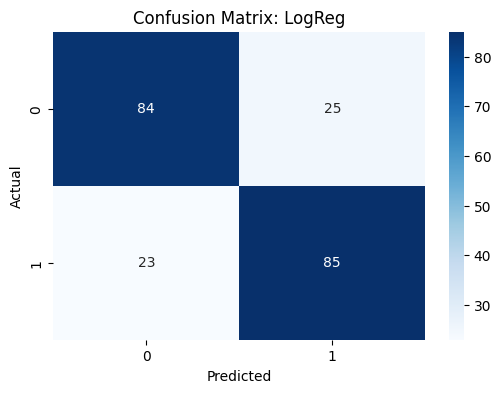

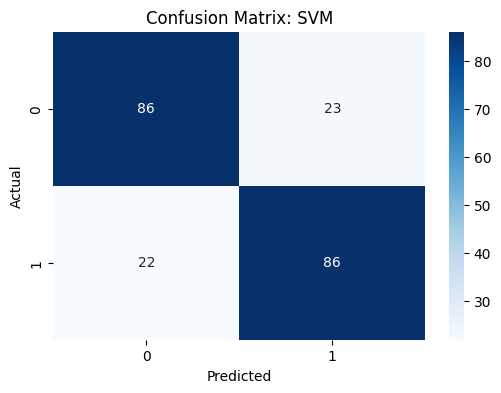

TypeError: Pipeline.predict() takes 2 positional arguments but 3 were given

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve

# Загружаем сохранённые pipeline
logreg_pipeline = load("LogReg_pipeline.pkl")
svm_pipeline = load("SVM_pipeline.pkl")

pipelines = {
    "LogReg": logreg_pipeline,
    "SVM": svm_pipeline
}

# === Матрицы ошибок ===
for name, pipe in pipelines.items():
    y_pred = pipe.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# === Bar plot с F1_macro и Accuracy ===
summary_metrics = []
for name, pipe in pipelines.items():
    y_pred = pipe.predict(X_test, 'communicative')
    acc = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    summary_metrics.append([name, f1_macro, acc])

summary_df = pd.DataFrame(summary_metrics, columns=["Model", "F1_macro", "Accuracy"])
summary_melt = summary_df.melt(id_vars="Model", var_name="Metric", value_name="Score")

plt.figure(figsize=(8,5))
sns.barplot(x="Model", y="Score", hue="Metric", data=summary_melt)
plt.ylim(0,1)
plt.title("Сравнение моделей: F1_macro и Accuracy")
plt.show()



LogReg - y_test unique: ['linguistic' 'communicative']
LogReg - y_pred unique: ['communicative' 'linguistic']


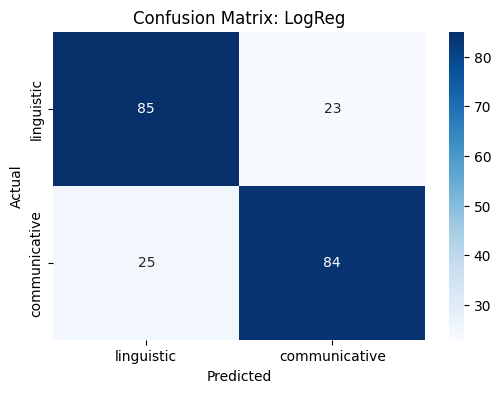

SVM - y_test unique: ['linguistic' 'communicative']
SVM - y_pred unique: ['communicative' 'linguistic']


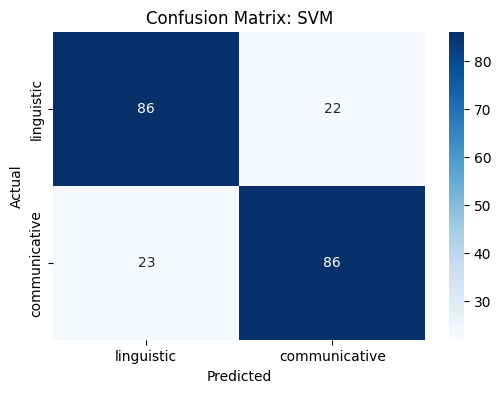

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Классы
class_labels = ['linguistic', 'communicative']

for name, pipe in pipelines.items():
    y_pred = pipe.predict(X_test)

    # Приводим к pd.Series с типом str
    y_test_str = pd.Series(y_test).astype(str)
    y_pred_str = pd.Series(y_pred).astype(str)

    # Проверяем, какие уникальные значения есть (для отладки)
    print(f"{name} - y_test unique:", y_test_str.unique())
    print(f"{name} - y_pred unique:", y_pred_str.unique())

    # Матрица ошибок
    cm = confusion_matrix(y_test_str, y_pred_str, labels=class_labels)

    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Confusion Matrix: {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


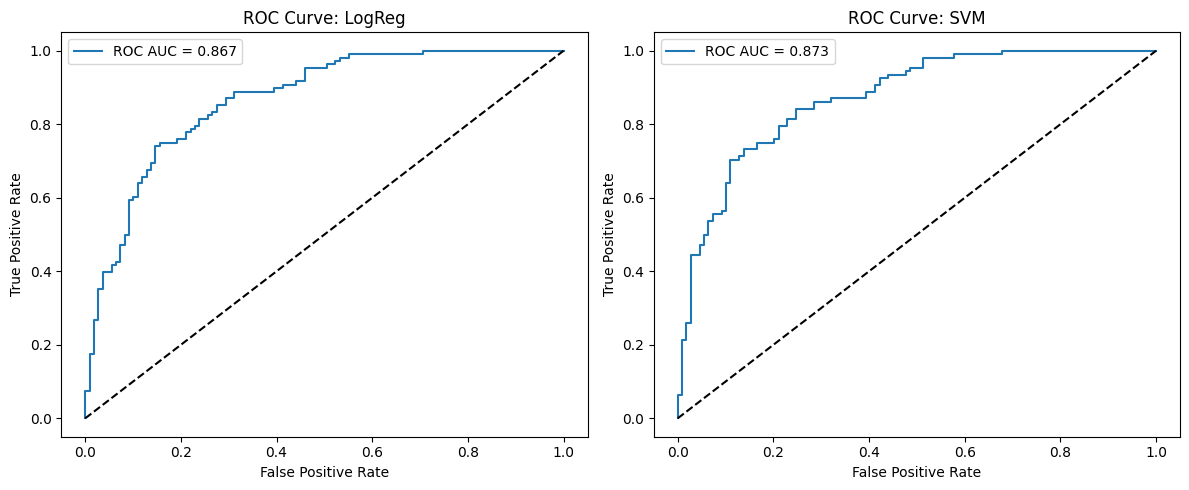

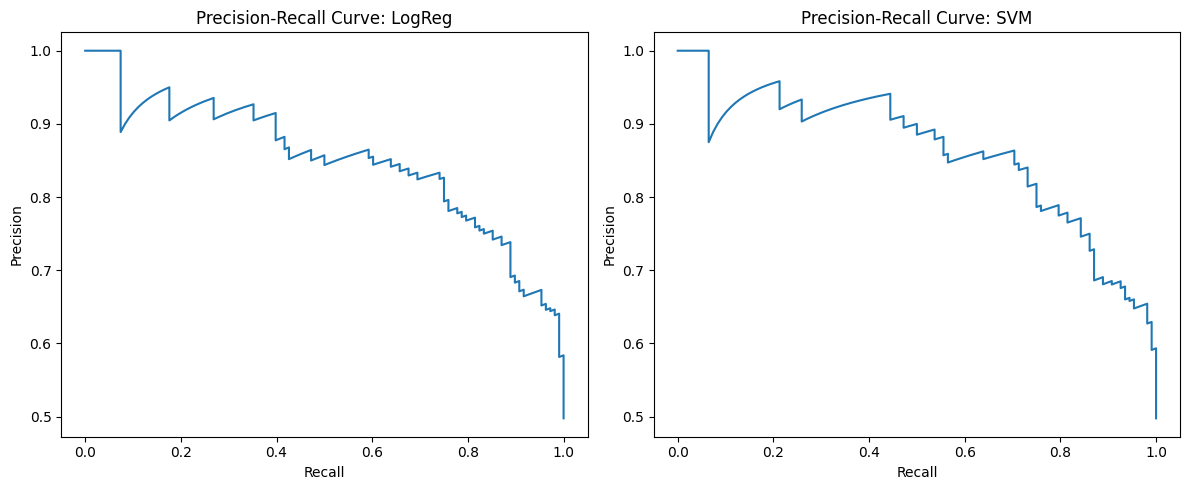

In [ ]:
# Для ROC и PR указываем pos_label
plt.figure(figsize=(12,5))
for i, (name, pipe) in enumerate(pipelines.items(), 1):
    y_score = pipe.predict_proba(X_test)[:,1]  # вероятность класса 'linguistic' (или нужного)

    plt.subplot(1,2,i)
    fpr, tpr, _ = roc_curve(y_test, y_score, pos_label='linguistic')  # указываем pos_label
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.3f}')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve: {name}')
    plt.legend()
plt.tight_layout()
plt.show()

# Precision-Recall
plt.figure(figsize=(12,5))
for i, (name, pipe) in enumerate(pipelines.items(), 1):
    y_score = pipe.predict_proba(X_test)[:,1]

    plt.subplot(1,2,i)
    precision, recall, _ = precision_recall_curve(y_test, y_score, pos_label='linguistic')
    plt.plot(recall, precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve: {name}')
plt.tight_layout()
plt.show()
